# 01 MNIST Loading Preprocessing

# Deep Learning e Computer Vision - VERSIONE DOCENTE

## Introduzione

Il **Deep Learning** è un sottoinsieme del Machine Learning basato su reti neurali artificiali con molteplici livelli ("deep" = profondo). Negli ultimi anni ha rivoluzionato campi come:
- Computer Vision (riconoscimento immagini)
- Natural Language Processing (traduzione, chatbot)
- Speech Recognition (assistenti vocali)
- Sistemi di raccomandazione
- Guida autonoma

### Perché Deep Learning?

**Vantaggi rispetto al ML classico:**
- **Apprendimento automatico delle feature**: non serve feature engineering manuale
- **Performance su grandi dataset**: scala meglio con più dati
- **Capacità di catturare pattern complessi**: gerarchie di rappresentazioni

**Svantaggi:**
- Richiede molti dati
- Computazionalmente intensivo (serve GPU)
- Meno interpretabile ("black box")
- Rischio di overfitting se non gestito correttamente

---

## 1. Che cos'è il Deep Learning

### Dall'AI al Deep Learning

```
Intelligenza Artificiale (AI)
    └── Machine Learning (ML)
            └── Deep Learning (DL)
```

- **AI**: campo generale che studia macchine intelligenti
- **ML**: subset di AI che impara dai dati senza programmazione esplicita
- **DL**: subset di ML basato su reti neurali profonde

### Evoluzione storica

1. **1943**: McCulloch-Pitts, primo modello neurone artificiale
2. **1958**: Perceptron di Rosenblatt
3. **1986**: Backpropagation (Rumelhart, Hinton, Williams)
4. **1998**: LeNet (Yann LeCun) per riconoscimento cifre
5. **2006**: Renaissance del DL (Hinton)
6. **2012**: AlexNet vince ImageNet, inizio dell'era moderna
7. **2017+**: Transformers (BERT, GPT) rivoluzionano NLP

### Fattori che hanno reso possibile il DL moderno

1. **Big Data**: miliardi di immagini, testi, video disponibili
2. **GPU**: calcolo parallelo massivo
3. **Algoritmi migliorati**: ReLU, dropout, batch normalization
4. **Framework**: TensorFlow, PyTorch rendono lo sviluppo accessibile

---

## 2. Reti Neurali Artificiali

### 2.1 Il Neurone Artificiale

Un **neurone artificiale** (o perceptron) è l'unità base delle reti neurali.

#### Componenti:

1. **Input**: $x_1, x_2, ..., x_n$
2. **Pesi**: $w_1, w_2, ..., w_n$ (parametri da apprendere)
3. **Bias**: $b$ (parametro da apprendere)
4. **Somma pesata**: $z = \sum_{i=1}^{n} w_i x_i + b$
5. **Funzione di attivazione**: $a = f(z)$
6. **Output**: $a$

#### Funzioni di attivazione comuni:

**Sigmoid**: $\sigma(z) = \frac{1}{1 + e^{-z}}$
- Output in [0, 1]
- Usata per probabilità
- Problema: vanishing gradient

**Tanh**: $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$
- Output in [-1, 1]
- Zero-centered (meglio di sigmoid)

**ReLU** (Rectified Linear Unit): $\text{ReLU}(z) = \max(0, z)$
- Semplice e efficace
- Standard per hidden layers
- Risolve vanishing gradient

**Softmax** (per output layer classificazione multi-classe):
$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$$

### 2.2 Architettura di una Rete Neurale

Una rete neurale è composta da **layer** (strati) di neuroni:

1. **Input Layer**: riceve i dati
2. **Hidden Layers**: uno o più strati intermedi
3. **Output Layer**: produce le predizioni

```
Input → Hidden 1 → Hidden 2 → ... → Output
```

**Deep Neural Network**: rete con molti hidden layers (≥ 2)

### 2.3 Forward Propagation

Il processo di calcolare l'output dato un input:

```
Layer 1: a[1] = f(W[1] · x + b[1])
Layer 2: a[2] = f(W[2] · a[1] + b[2])
...
Output:  ŷ = a[L]
```

### 2.4 Backpropagation e Training

**Obiettivo**: minimizzare la loss function rispetto ai parametri

1. **Forward pass**: calcola predizioni
2. **Calcola loss**: $L(\hat{y}, y)$
3. **Backward pass**: calcola gradienti con chain rule
4. **Update parametri**: $w := w - \alpha \frac{\partial L}{\partial w}$

**Loss functions comuni:**
- **Regressione**: Mean Squared Error (MSE)
- **Classificazione binaria**: Binary Cross-Entropy
- **Classificazione multi-classe**: Categorical Cross-Entropy

---

## 3. Setup: PyTorch

**PyTorch** è un framework open-source di Meta per deep learning.
Offre un'API intuitiva e flessibile per costruire e addestrare reti neurali, con supporto nativo per GPU.

In [1]:
# Import librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

# Scikit-learn per preprocessing e metriche
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Impostazioni
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Device: {device}")
print(f"CUDA disponibile: {torch.cuda.is_available()}")

import os, urllib.request

# GitHub Release URL for pretrained weights
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            # Also try downloading history
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

PyTorch version: 2.10.0+cu128
Torchvision version: 0.25.0+cu128
Device: cuda
CUDA disponibile: True


---

## 4. Prima Rete Neurale: Classificazione con MNIST

**MNIST** è un dataset classico di cifre scritte a mano (0-9):
- 60,000 immagini di training
- 10,000 immagini di test
- Dimensione: 28x28 pixel in scala di grigi

### 4.1 Caricamento Dati

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 457kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.7MB/s]


Training set: (60000, 28, 28)
Test set: (10000, 28, 28)

Range valori pixel: [0, 255]
Classi: [0 1 2 3 4 5 6 7 8 9]


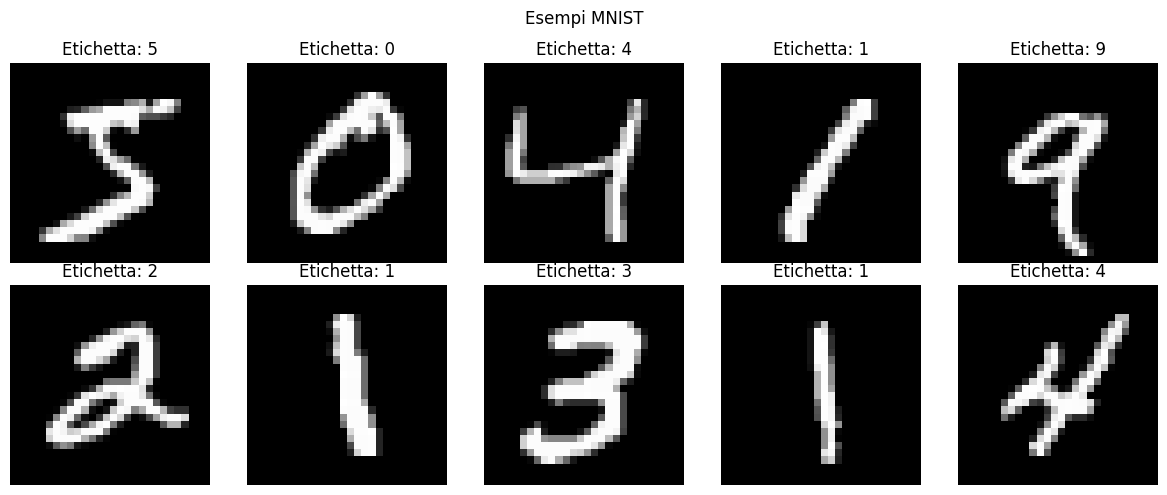

In [2]:
# Caricamento MNIST da torchvision
mnist_train = torchvision.datasets.MNIST(root='../data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True)

X_train = mnist_train.data.numpy()  # (60000, 28, 28)
y_train = mnist_train.targets.numpy()
X_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nRange valori pixel: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {np.unique(y_train)}")

# Visualizzazione esempi
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Etichetta: {y_train[i]}")
    ax.axis('off')
plt.suptitle('Esempi MNIST')
plt.tight_layout()
plt.show()

### 4.2 Preprocessing

Per una rete neurale fully-connected:
1. **Flatten**: trasformare immagini 28x28 in vettori 784
2. **Normalizzazione**: scalare pixel da [0, 255] a [0, 1]

In [3]:
# Flatten: da (28, 28) a (784,)
X_train_flat = X_train.reshape(-1, 28 * 28)
X_test_flat = X_test.reshape(-1, 28 * 28)

print(f"Shape dopo flatten:")
print(f"  Training: {X_train_flat.shape}")
print(f"  Test: {X_test_flat.shape}")

# Normalizzazione
X_train_norm = X_train_flat / 255.0
X_test_norm = X_test_flat / 255.0

print(f"\nRange dopo normalizzazione: [{X_train_norm.min():.2f}, {X_train_norm.max():.2f}]")

Shape dopo flatten:
  Training: (60000, 784)
  Test: (10000, 784)

Range dopo normalizzazione: [0.00, 1.00]
